<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "3A"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/3A/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


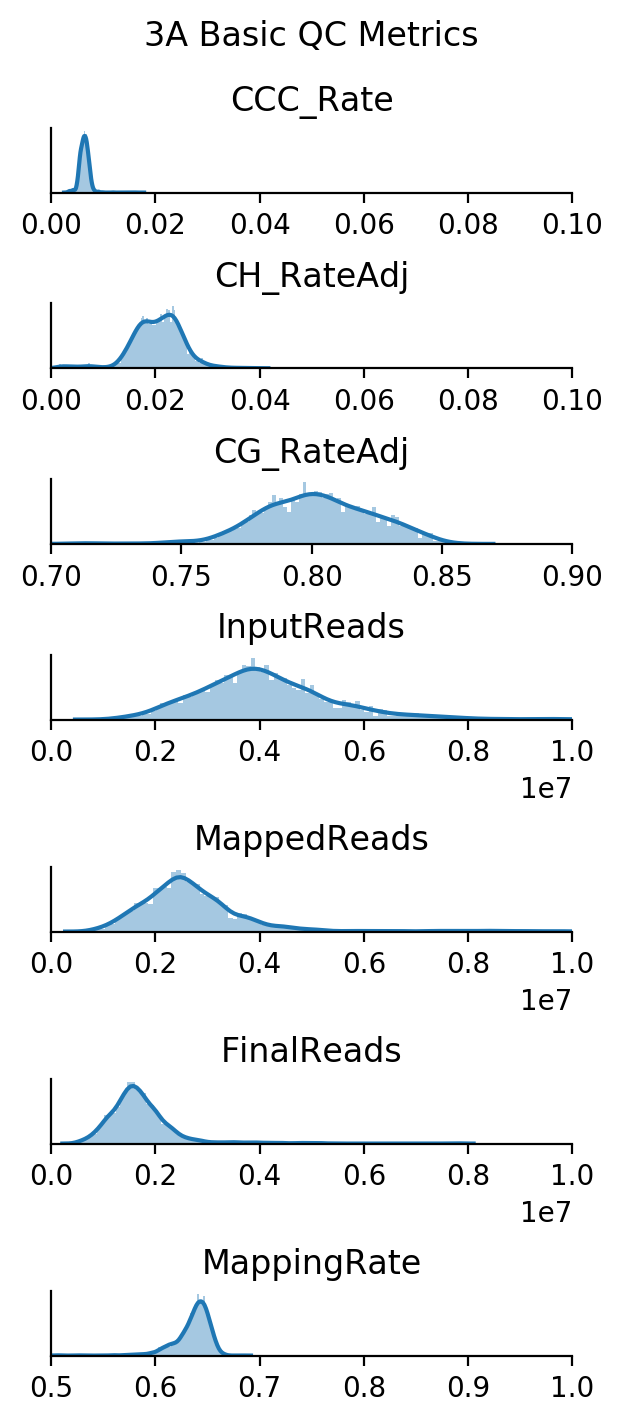

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

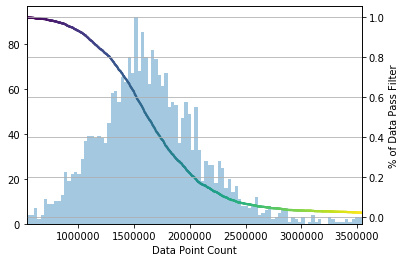

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2590/2590 (100.0%)
CG_RateAdj passed 2590/2590 (100.0%)
CH_RateAdj passed 2590/2590 (100.0%)
FinalReads passed 2590/2590 (100.0%)
MappingRate passed 2590/2590 (100.0%)
Overall passed 2590/2590 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180129 1347
180130 1243


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 317 82.6%
ad002 323 84.1%
ad004 320 83.3%
ad006 324 84.4%
ad007 321 83.6%
ad008 321 83.6%
ad010 332 86.5%
ad012 332 86.5%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
3A_M_0,/gale/raidix/rdx-4/CEMBA_RS1/3A/CEMBA180129_3A...,0.00617,0.80902,0.80783,0.02460,0.01854,1991991.0,4751680,3088376.0,3A,...,11.766138,-5.211295,-3.772175,-17.561588,IT-L6 Man1c1,-15.368646,-4.629686,32.228388,-15.131304,True
3A_M_1,/gale/raidix/rdx-4/CEMBA_RS1/3A/CEMBA180129_3A...,0.00816,0.81577,0.81425,0.03535,0.02741,1715318.0,4096726,2687323.0,3A,...,25.769119,8.165702,-15.398007,-41.479745,CT-L6 Megf9,0.145992,-20.756325,-7.758425,-35.366024,True
3A_M_10,/gale/raidix/rdx-4/CEMBA_RS1/3A/CEMBA180129_3A...,0.00657,0.79805,0.79671,0.02685,0.02041,1369727.0,3204806,2083643.0,3A,...,8.760849,-10.566518,9.550773,16.150105,IT-L5 Cdh8,0.296548,6.282931,22.114458,-4.885473,True
3A_M_100,/gale/raidix/rdx-4/CEMBA_RS1/3A/CEMBA180129_3A...,0.00723,0.84134,0.84018,0.02907,0.02200,2216323.0,5669408,3546647.0,3A,...,25.870062,1.442672,-2.349569,-38.742391,NP-L6 Olfml2b,4.704943,-1.750759,4.232302,0.241423,True
3A_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/3A/CEMBA180129_3A...,0.00716,0.80356,0.80214,0.03051,0.02352,1114621.0,2704038,1758699.0,3A,...,8.943070,9.015114,52.308877,13.298157,PT-L5 Tenm2,-14.855749,6.167174,-11.592526,10.226714,True
3A_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/3A/CEMBA180129_3A...,0.00561,0.78089,0.77965,0.02278,0.01727,1463695.0,3432770,2184618.0,3A,...,3.566603,-10.874303,-11.706675,21.565597,IT-L23 Foxp1,-3.861756,-0.098812,-34.370326,5.335076,True
3A_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/3A/CEMBA180129_3A...,0.00601,0.76948,0.76809,0.02362,0.01772,1224767.0,2811516,1837444.0,3A,...,1.732147,-8.583085,-22.334340,23.445115,IT-L23 Tenm2,0.948604,-2.796656,-3.266114,45.660600,True
3A_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/3A/CEMBA180129_3A...,0.00764,0.83352,0.83224,0.03451,0.02708,2715163.0,6183808,4076091.0,3A,...,-20.065857,-15.948538,-32.923074,-41.042598,CGE-Vip Robo1,-10.977835,0.069908,-15.062239,22.924891,True
3A_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/3A/CEMBA180129_3A...,0.00596,0.80203,0.80084,0.02481,0.01896,1403731.0,3390074,2119723.0,3A,...,5.058540,-10.137833,-4.451997,18.622611,IT-L23 Foxp1,-5.290885,-2.107190,-45.012097,7.101296,True
3A_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/3A/CEMBA180129_3A...,0.00803,0.78636,0.78463,0.02364,0.01574,1321711.0,3123674,2018749.0,3A,...,2.234102,-9.430158,-18.983146,23.740938,IT-L23 Tenm2,0.762710,-2.444779,-4.850264,40.769034,True
